# oblik rift 25 degree

In [1]:




import UWGeodynamics as GEO
import glucifer


# In[2]:

u = GEO.UnitRegistry


# In[3]:

# Characteristic values of the system
half_rate = 1.0 * u.centimeter / u.year
model_length = 448e3 * u.meter
model_width = 448e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2 #3300

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"] = KM
GEO.scaling_coefficients["[temperature]"] = KT


# In[4]:

resolution = (32, 32, 16)
Model = GEO.Model(elementRes=resolution,
                  minCoord=(0. * u.kilometer, 0. * u.kilometer, -184. * u.kilometer),
                  maxCoord=(448. * u.kilometer, 448. * u.kilometer, 8. * u.kilometer),
                  gravity=(0.0, 0.0, -9.81 * u.meter / u.second**2))

# ## Global definitions

# In[5]:

Model.outputDir="outputs"



loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
Model.maxViscosity  = 5e23 * u.pascal * u.second
Model.minViscosity  = 1e19 * u.pascal * u.second
Model.stressLimiter = 300. * u.megapascal
Model.diffusivity = 1e-6 * u.metre**2 / u.second
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)


# ## Define Materials
#
air_shape         = GEO.shapes.Layer(top = Model.top,         bottom = 0.0)

air = Model.add_material(name="Air", shape=air_shape)
Ucrust = Model.add_material(name="UpperCrust", shape=GEO.shapes.Layer3D(top=air.bottom, bottom=-20 * u.kilometer))
Lcrust = Model.add_material(name="LowerCrust", shape=GEO.shapes.Layer3D(top=Ucrust.bottom, bottom=-35 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer3D(top=Lcrust.bottom, bottom=-140 * u.kilometer))
mantle_shape      = GEO.shapes.Layer(top=-140*u.kilometer,  bottom=Model.bottom)
mantle = Model.add_material(name="Mantle", shape=mantle_shape)

sediment   = Model.add_material(name="Sediment")

In [3]:
# ## Passive Tracers
#


import numpy as np

xp = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 100)
yp = np.linspace(GEO.nd(Model.minCoord[1]), GEO.nd(Model.maxCoord[1]), 100)

xp, yp = np.meshgrid(xp, yp)
xp = xp.flatten()
yp = yp.flatten()
zp = np.zeros(xp.shape)

surface_tracers = Model.add_passive_tracers(name="Surface", vertices=[xp, yp, zp])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[xp, yp, zp+GEO.nd(mantleLithosphere.top)])
Lab_tracers = Model.add_passive_tracers(name="Lab", vertices=[xp,yp,-90.*u.kilometer])



# ## Temperature Boundary Condition


Model.set_temperatureBCs(top=273.15 * u.degK,
                         bottom=1623.15 * u.degK,
                         materials = [(air, 273.15 * u.degK), (mantle, 1623.15 * u.degK)])









Model.init_model()

Model.set_temperatureBCs(top=273.15 * u.degK,
                         bottom=1623.15 * u.degK)


#air.compressibility = 1e4  # Not sure what's a good value is

#P, bottomPress = Model.get_lithostatic_pressureField()


# Get the average of the pressure along the bottom, and make it a pressure BC along the bottom
#bottomPress = GEO.Dimensionalize(numpy.average(bottomPress), u.megapascal)



# ## Velocity Boundary Conditions
#
# We pull on the left and right side. The back and front wall are freeslip. We use a pseudo isostatic support condition at the bottom.

# In[30]:

Model.set_velocityBCs(left=[-0.35* u.centimeter / u.year, 0., None],
                      right=[0.35 * u.centimeter / u.year, 0., None],
                      back=[None, 0., None],
                      front=[None, 0., None],
                      bottom=GEO.LecodeIsostasy(reference_mat=mantle,
                                                average=True))





# ## Initial Plastic Strain

import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.25
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
centers = 0.3 * Model.swarm.particleCoordinates.data[:,1] + 0.34
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], centers, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,2], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))




# # Surface Processes / BADLANDS

# Model.surfaceProcesses = GEO.surfaceProcesses.Badlands(airIndex=[air.index], sedimentIndex=sediment.index,
#                                             XML="resources/badlands.xml", resolution=1. * u.kilometer,
#                                             checkpoint_interval=0.005 * u.megayears)



GEO.rcParams["initial.nonlinear.tolerance"] = 1e-2 #1e-3
GEO.rcParams["nonlinear.tolerance"] = 1e-3 #1e-3
GEO.rcParams["swarm.particles.per.cell.3D"] = 60
GEO.rcParams["popcontrol.particles.per.cell.3D"] = 60



#Model.run_for(50.0 * u.megayears, checkpoint_interval=0.005 * u.megayears, restart_checkpoint=5)



In [4]:
#Model.run_for(50.0 * u.megayears, checkpoint_interval=0.005 * u.megayears)


## tests

In [5]:
import matplotlib.pyplot as plt

In [6]:
mohoT = Model.temperature.evaluate(moho_tracers.swarm)[:,0].mean()
print("Moho Temperature = ", GEO.Dimensionalize(mohoT, u.degC)) 
LabT = Model.temperature.evaluate(Lab_tracers.swarm)[:,0].mean()
print("Lab Temperature = ", GEO.Dimensionalize(LabT, u.degC)) 



('Moho Temperature = ', <Quantity(335.963064631, 'degC')>)
('Lab Temperature = ', <Quantity(757.08020383, 'degC')>)


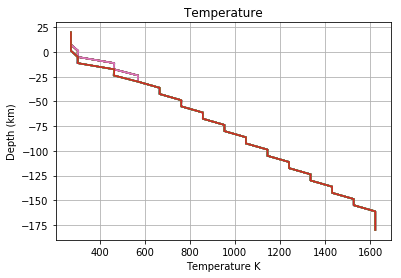

In [7]:
MyTemperatureField=(Model.temperature.data[:] * GEO.Dimensionalize(1.0, u.degK)).magnitude 

TemperatureData=np.asarray(MyTemperatureField)
TemperatureDataShaped=TemperatureData.reshape(resolution[1]+1,resolution[0]+1,resolution[2]+1)

#Two profiles located at the left walls and the middle.
plt.plot(TemperatureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(TemperatureDataShaped[:, resolution[2]/2], np.linspace(Model.bottom,Model.top,resolution[1]+1))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Temperature K')
plt.ylabel('Depth (km)')
plt.title('Temperature')
plt.show()

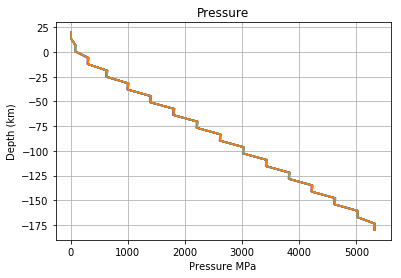

In [8]:
MyPressureField=(Model.pressureField.data[:] * GEO.Dimensionalize(1.0, u.megapascal)).magnitude 

PressureData=np.asarray(MyPressureField)
PressureDataShaped=PressureData.reshape(resolution[1],resolution[0],resolution[2])

#Two profiles located at the left walls and the middle.
plt.plot(PressureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(PressureDataShaped[:,resolution[2]/2], np.linspace(Model.bottom,Model.top,resolution[1]))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Pressure MPa')
plt.ylabel('Depth (km)')
plt.title('Pressure')
plt.show()



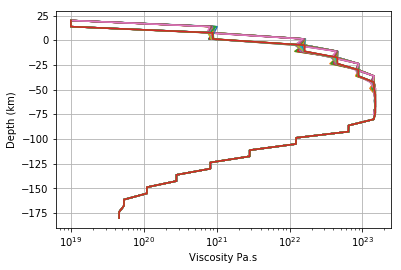

In [9]:
MyViscosityField=(Model.projViscosityField.data[:] * GEO.Dimensionalize(1.0, u.pascal * u.second)).magnitude 

ViscosityData=np.asarray(MyViscosityField)
ViscosityDataShaped=ViscosityData.reshape(resolution[1]+1,resolution[0]+1,resolution[2]+1)

#Two profiles located at the left walls and the middle.
plt.plot(ViscosityDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(ViscosityDataShaped[:,resolution[0]/2], np.linspace(Model.bottom,Model.top,resolution[1]+1))



## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
plt.xscale('log')
plt.xlabel('Viscosity Pa.s')
plt.ylabel('Depth (km)')
## plt.title('Viscosity')
plt.show()



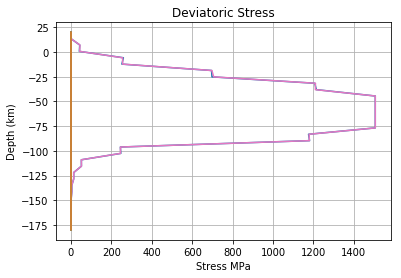

In [10]:
MyStressField=(Model.projStressField.data[:] * GEO.Dimensionalize(1.0, u.megapascal)).magnitude 

StressData=np.asarray(MyStressField)
StressDataShaped=StressData.reshape(resolution[1],resolution[0],resolution[2])

#Two profiles located at the left walls and the middle.

plt.plot(StressDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(StressDataShaped[:,resolution[0]/2], np.linspace(Model.bottom,Model.top,resolution[1]))


## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
plt.xlabel('Stress MPa')
plt.ylabel('Depth (km)')
plt.title('Deviatoric Stress')
plt.show()

In [ ]:
#Model.run_for(20.0 * u.megayears, checkpoint_interval=0.01 * u.megayears)